Exploring some of the EVHUB Data. Here's a (very) rough starting point for Florida.

In [3]:
#import geoplot as gplt
import geopandas as gpd
#import geoplot.crs as gcrs
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import mapclassify as mc
import numpy as np
from geopy.geocoders import Nominatim
from shapely.geometry import Point
import os
from pandasql import sqldf
import matplotlib.pyplot as plt
import matplotlib as mpl
import datetime
import numpy as np
pysqldf = lambda q: sqldf(q, globals())
pd.set_option('display.max_columns', None)

#fl_df = pd.read_csv("./EVHUB/Data/registrations/fl_ev_registrations_public.csv")
#fl_df.head(3)

In [4]:
US_sf = gpd.read_file("./Data/GIS/cb_2018_us_county_5m/cb_2018_us_county_5m.shp")

#Removing the outlying islands and other territories. 
US_sf["STATEFP"] =pd.to_numeric(US_sf["STATEFP"])
US_sf = US_sf[US_sf['STATEFP'] < 57]
US_sf = US_sf[US_sf['COUNTYNS'] != "01419965"]
US_sf.head(3)

,STATEFP,COUNTYFP,COUNTYNS,AFFGEOID,GEOID,NAME,LSAD,ALAND,AWATER,geometry
0,39,071,01074048,0500000US39071,39071,Highland,06,1432479992,12194983,"POLYGON ((-83.86976 39.05553, -83.86568 39.247..."
1,6,003,01675840,0500000US06003,6003,Alpine,06,1912292630,12557304,"POLYGON ((-120.07248 38.50987, -120.07239 38.7..."
2,12,033,00295737,0500000US12033,12033,Escambia,06,1701544502,563927612,"POLYGON ((-87.62999 30.87766, -87.62946 30.880..."


In [5]:
station_data = pd.read_csv("./Data/Transport/alt_fuel_stations.csv")

print(station_data.columns.tolist())

['Fuel Type Code', 'Station Name', 'Street Address', 'Intersection Directions', 'City', 'State', 'ZIP', 'Plus4', 'Station Phone', 'Status Code', 'Expected Date', 'Groups With Access Code', 'Access Days Time', 'Cards Accepted', 'BD Blends', 'NG Fill Type Code', 'NG PSI', 'EV Level1 EVSE Num', 'EV Level2 EVSE Num', 'EV DC Fast Count', 'EV Other Info', 'EV Network', 'EV Network Web', 'Geocode Status', 'Latitude', 'Longitude', 'Date Last Confirmed', 'ID', 'Updated At', 'Owner Type Code', 'Federal Agency ID', 'Federal Agency Name', 'Open Date', 'Hydrogen Status Link', 'NG Vehicle Class', 'LPG Primary', 'E85 Blender Pump', 'EV Connector Types', 'Country', 'Intersection Directions (French)', 'Access Days Time (French)', 'BD Blends (French)', 'Groups With Access Code (French)', 'Hydrogen Is Retail', 'Access Code', 'Access Detail Code', 'Federal Agency Code', 'Facility Type', 'CNG Dispenser Num', 'CNG On-Site Renewable Source', 'CNG Total Compression Capacity', 'CNG Storage Capacity', 'LNG On-S

C:\Users\jhawkins17\AppData\Local\Temp\ipykernel_19304\1386725465.py:1: DtypeWarning: Columns (6,20) have mixed types. Specify dtype option on import or set low_memory=False.
  station_data = pd.read_csv("./Data/Transport/alt_fuel_stations.csv")


In [6]:
geometry = [Point(xy) for xy in zip(station_data.Longitude, station_data.Latitude)]
crs = {'init' :'epsg:4326'}
station_points = gpd.GeoDataFrame(station_data, crs=crs, geometry=geometry)

station_points = gpd.sjoin(station_points, US_sf, how='left', op='within')

merged_df = pd.DataFrame(station_points)
merged_df

num_stations = merged_df['COUNTYNS'].value_counts()
num_stations = pd.DataFrame(num_stations)
num_stations = num_stations.reset_index()
num_stations.columns = ['COUNTYNS','Charging Stations']

num_stations

C:\Users\jhawkins17\AppData\Local\Programs\Python\Python310\lib\site-packages\pyproj\crs\crs.py:130: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)
C:\Users\jhawkins17\AppData\Local\Programs\Python\Python310\lib\site-packages\IPython\core\interactiveshell.py:3338: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):
C:\Users\jhawkins17\AppData\Local\Temp\ipykernel_19304\1247847374.py:5: UserWarning: CRS mismatch between the CRS of left geometries and the CRS of right geometries.
Use `to_crs()` to reproject one of the input geometries to match the CRS of the other.

Left CRS: +init=e

,COUNTYNS,Charging Stations
0,00277283,3508
1,00277307,1658
2,00277294,1539
3,00277301,1111
4,00277305,1078
...,...,...
1895,01690257,1
1896,01702378,1
1897,01494434,1
1898,01494551,1


In [7]:
final = pd.merge(US_sf, num_stations, on = 'COUNTYNS', how = 'left')
final['Charging Stations'] = final['Charging Stations'].fillna(0)

Here is charging stations per county:

In [8]:
## Number of Charging stations per county
ax = gplt.choropleth(
  final[final['STATEFP'] == 6],
  hue = "Charging Stations",
  edgecolor='darkgrey',
  linewidth=.5,
  cmap="viridis",
  legend=True,
  projection=gcrs.AlbersEqualArea(),
  figsize = (16,16),
  zorder = 1
)

gplt.pointplot(
  station_points[station_points['STATEFP'] == 6],
  projection=gcrs.AlbersEqualArea(),
  ax = ax,
  zorder = 2,
  s = .4
)

NameError: name 'gplt' is not defined

Here is charging stations per capita:

In [11]:
census = pd.read_csv('../Data/Census/TotalPopulation_Sex_Age_Race/nhgis0001_ds244_20195_county_E.csv', encoding='latin-1')

# ALT0E001 is total population estimate per county
final['AFFGEOID'] = final['AFFGEOID'].map(lambda x: x.lstrip('0500000'))
census['GEOID'] = census['GEOID'].map(lambda x: x.lstrip('05000'))
stations_census = pd.merge(final, census, left_on= "AFFGEOID", right_on="GEOID", how = "left")

stations_census["Stations per Capita"] = stations_census["Charging Stations"]/stations_census["ALT0E001"]*1000

# State codes to plot
states = [41,53,6,32]

# Plotting
ax = gplt.choropleth(
  stations_census[stations_census['STATEFP'].isin(states)],
  hue = "Stations per Capita",
  edgecolor='darkgrey',
  linewidth=.5,
  cmap="plasma",
  legend=True,
  projection=gcrs.AlbersEqualArea(),
  figsize = (16,16),
  zorder = 1,
)

gplt.pointplot(
  station_points[station_points['STATEFP'].isin(states)],
  projection=gcrs.AlbersEqualArea(),
  ax = ax,
  color = 'white',
  zorder = 2,
  s = .2,
)

FileNotFoundError: [Errno 2] No such file or directory: '../Data/Census/TotalPopulation_Sex_Age_Race/nhgis0001_ds244_20195_county_E.csv'

In [10]:
stations_census.sort_values(by = "Stations per Capita", ascending = False, inplace = True)

stations_census[['COUNTY', 'STATE','Stations per Capita']].head(20)


NameError: name 'stations_census' is not defined

In [9]:

#  https://gist.github.com/rogerallen/1583593
us_state_to_abbrev = {
    "Alabama": "AL",
    "Alaska": "AK",
    "Arizona": "AZ",
    "Arkansas": "AR",
    "California": "CA",
    "Colorado": "CO",
    "Connecticut": "CT",
    "Delaware": "DE",
    "Florida": "FL",
    "Georgia": "GA",
    "Hawaii": "HI",
    "Idaho": "ID",
    "Illinois": "IL",
    "Indiana": "IN",
    "Iowa": "IA",
    "Kansas": "KS",
    "Kentucky": "KY",
    "Louisiana": "LA",
    "Maine": "ME",
    "Maryland": "MD",
    "Massachusetts": "MA",
    "Michigan": "MI",
    "Minnesota": "MN",
    "Mississippi": "MS",
    "Missouri": "MO",
    "Montana": "MT",
    "Nebraska": "NE",
    "Nevada": "NV",
    "New Hampshire": "NH",
    "New Jersey": "NJ",
    "New Mexico": "NM",
    "New York": "NY",
    "North Carolina": "NC",
    "North Dakota": "ND",
    "Ohio": "OH",
    "Oklahoma": "OK",
    "Oregon": "OR",
    "Pennsylvania": "PA",
    "Rhode Island": "RI",
    "South Carolina": "SC",
    "South Dakota": "SD",
    "Tennessee": "TN",
    "Texas": "TX",
    "Utah": "UT",
    "Vermont": "VT",
    "Virginia": "VA",
    "Washington": "WA",
    "West Virginia": "WV",
    "Wisconsin": "WI",
    "Wyoming": "WY",
    "District of Columbia": "DC",
    "American Samoa": "AS",
    "Guam": "GU",
    "Northern Mariana Islands": "MP",
    "Puerto Rico": "PR",
    "United States Minor Outlying Islands": "UM",
    "U.S. Virgin Islands": "VI",
}

In [12]:
US_sf_state = gpd.read_file("../Data/GIS/cb_2020_us_state_5m/cb_2020_us_state_5m.shp")


#Removing the outlying islands and other territories.
US_sf_state["STATEFP"] =pd.to_numeric(US_sf_state["STATEFP"])
US_sf_state = US_sf_state[US_sf_state['STATEFP'] < 60]
US_sf_state.head()

DriverError: ../Data/GIS/cb_2020_us_state_5m/cb_2020_us_state_5m.shp: No such file or directory

In [11]:
egrid_state = pd.read_excel("./Data/eGrid/egrid2020_data.xlsx", sheet_name="ST20")

# Removing first row
new_header = egrid_state.iloc[0] #grab the first row for the header
egrid_state = egrid_state[1:] #take the data less the header row
egrid_state.columns = new_header #set the header row as the df header

egrid_state['FIPSST'] = egrid_state['FIPSST'].astype(int)

egrid_state = US_sf_state.merge(egrid_state, left_on= "STATEFP", right_on="FIPSST", how = "left")
egrid_state.head()

,STATEFP,STATENS,AFFGEOID,GEOID,STUSPS,NAME,LSAD,ALAND,AWATER,geometry,YEAR,PSTATABB,FIPSST,STNAMEPCAP,STHTIAN,STHTIOZ,STHTIANT,STHTIOZT,STNGENAN,STNGENOZ,STNOXAN,STNOXOZ,STSO2AN,STCO2AN,STCH4AN,STN2OAN,STCO2EQA,STHGAN,STNOXRTA,STNOXRTO,STSO2RTA,STCO2RTA,STCH4RTA,STN2ORTA,STC2ERTA,STHGRTA,STNOXRA,STNOXRO,STSO2RA,STCO2RA,STCH4RA,STN2ORA,STC2ERA,STHGRA,STNOXCRT,STNOXCRO,STSO2CRT,STCO2CRT,STCH4CRT,STN2OCRT,STC2ECRT,STHGCRT,STCNOXRT,STONOXRT,STGNOXRT,STFSNXRT,STCNXORT,STONXORT,STGNXORT,STFSNORT,STCSO2RT,STOSO2RT,STGSO2RT,STFSS2RT,STCCO2RT,STOCO2RT,STGCO2RT,STFSC2RT,STCCH4RT,STOCH4RT,STGCH4RT,STFCH4RT,STCN2ORT,STON2ORT,STGN2ORT,STFN2ORT,STCC2ERT,STOC2ERT,STGC2ERT,STFSC2ERT,STCHGRT,STFSHGRT,STCNOXR,STONOXR,STGNOXR,STFSNXR,STCNXOR,STONXOR,STGNXOR,STFSNOR,STCSO2R,STOSO2R,STGSO2R,STFSS2R,STCCO2R,STOCO2R,STGCO2R,STFSC2R,STCCH4R,STOCH4R,STGCH4R,STFCH4R,STCN2OR,STON2OR,STGN2OR,STFN2OR,STCC2ER,STOC2ER,STGC2ER,STFSC2ER,STCHGR,STFSHGR,STNBNOX,STNBNXO,STNBSO2,STNBCO2,STNBCH4,STNBN2O,STNBC2E,STNBHG,STGENACL,STGENAOL,STGENAGS,STGENANC,STGENAHY,STGENABM,STGENAWI,STGENASO,STGENAGT,STGENAOF,STGENAOP,STGENATN,STGENATR,STGENATH,STGENACY,STGENACN,STCLPR,STOLPR,STGSPR,STNCPR,STHYPR,STBMPR,STWIPR,STSOPR,STGTPR,STOFPR,STOPPR,STTNPR,STTRPR,STTHPR,STCYPR,STCNPR,STNBGNCL,STNBGNOL,STNBGNGS,STNBGNNC,STNBGNHY,STNBGNBM,STNBGNWI,STNBGNSO,STNBGNGT,STNBGNOF,STNBGNOP,STNBCLPR,STNBOLPR,STNBGSPR,STNBNCPR,STNBHYPR,STNBBMPR,STNBWIPR,STNBSOPR,STNBGTPR,STNBOFPR,STNBOPPR
0,55,01779806,0400000US55,55,WI,Wisconsin,00,140292246684,29343721650,"MULTIPOLYGON (((-86.95620 45.35201, -86.95339 ...",2020,WI,55,23175.6,433879535.632,201721645.503,474552399.563,216985070.46,61440537.516,27439014.159,14997.159,7104.866,6256.568,36399785.544,6502984.187,931186.116,36618927.565,--,0.488,0.518,0.204,1184.878,0.106,0.015,1192.012,--,0.069,0.07,0.029,167.788,0.015,0.002,168.798,--,0.638,0.677,0.266,1547.838,0.138,0.02,1557.157,--,0.757,0.902,0.371,0.572,0.732,0.898,0.465,0.611,0.407,2.326,0.052,0.242,2177.277,1420.499,932.503,1575.784,0.2421,0.262,0.0178,0.1342,0.0353,0.0376,0.0019,0.0192,2193.846,1438.245,933.523,1584.872,--,--,0.073,0.094,0.047,0.062,0.071,0.1,0.055,0.065,0.039,0.243,0.007,0.026,209.117,148.476,118.722,171.687,0.0233,0.0274,0.0023,0.0146,0.0034,7.8551,0.0002,0.0021,210.709,150.331,118.852,172.677,--,--,0.806,0.844,0.315,1664.469,0.157,0.023,1675.024,--,23761097.163,105258.808,22002167.472,9771333,2787756.85,1149091.173,1763375,85008,0,9173.945,6275.9,55655306.288,5785231.023,2997474.173,47033064.461,14407472.85,0.386733,0.001713,0.358105,0.159037,0.045373,0.018702,0.028701,0.001384,0,0.000149,0.000102,0.90584,0.09416,0.048787,0.765505,0.234495,12735641.149487,141605.002,9796078.648142,0,0,606086.384402,0,0,0,0,0,0.547077,0.006083,0.420804,0,0,0.026035,0,0,0,0,0
1,54,01779805,0400000US54,54,WV,West Virginia,00,62266296765,489206049,"POLYGON ((-82.64300 38.16956, -82.63905 38.171...",2020,WV,54,20872.7,538212125.808,264335617.544,568828395.824,274160274.572,56661533.092,26962465.829,30103.857,14531.527,33651.954,54102287.169,12500386.554,1816087.72,54529139.071,--,1.063,1.078,1.188,1909.665,0.221,0.032,1924.732,--,0.112,0.11,0.125,201.044,0.023,0.003,202.631,--,1.132,1.149,1.266,2035.003,0.235,0.034,2051.059,--,1.16,0,0.608,1.132,1.152,0,0.633,1.124,1.333,0,0.01,1.266,2084.254,0,1115.976,2034.607,0.2467,0,0.02,0.235,0.0359,0,0.002,0.0341,2101.115,0,1117.073,2050.66,--,--,0.114,0,0.065,0.112,0.112,0,0.064,0.11,0.131,0,0.001,0.125,205.184,0,118.593,201.055,0.0243,0,0.0021,0.0232,0.0035,0,0.0002,0.0034,206.844,0,118.71,202.642,--,--,1.156,1.139,1.197,2074.65,0.24,0.035,2091.027,--,50216397.839,142407.5,2776672.956,0,1592025,6457,1897803,0,0,46560.567,-16791,53165247.862,3496285,1904260,53171704.862,3489828,0.885989,0.002513,0.04899,0,0.028089,0.000114,0.033484,0,0,0.000821,0,0.938295,0.061705,0.033598,0.938409,0.061591,27006390.433799,0,1203381.613493,0,0,6130.449141,0,0,0,0,0,0.957134,0,0.042649,0,0,0.000217,0,0,0,0,0
2,16,01779783,0400000US16,16,ID,Idaho,00,214049923496,2

<GeoAxesSubplot:>

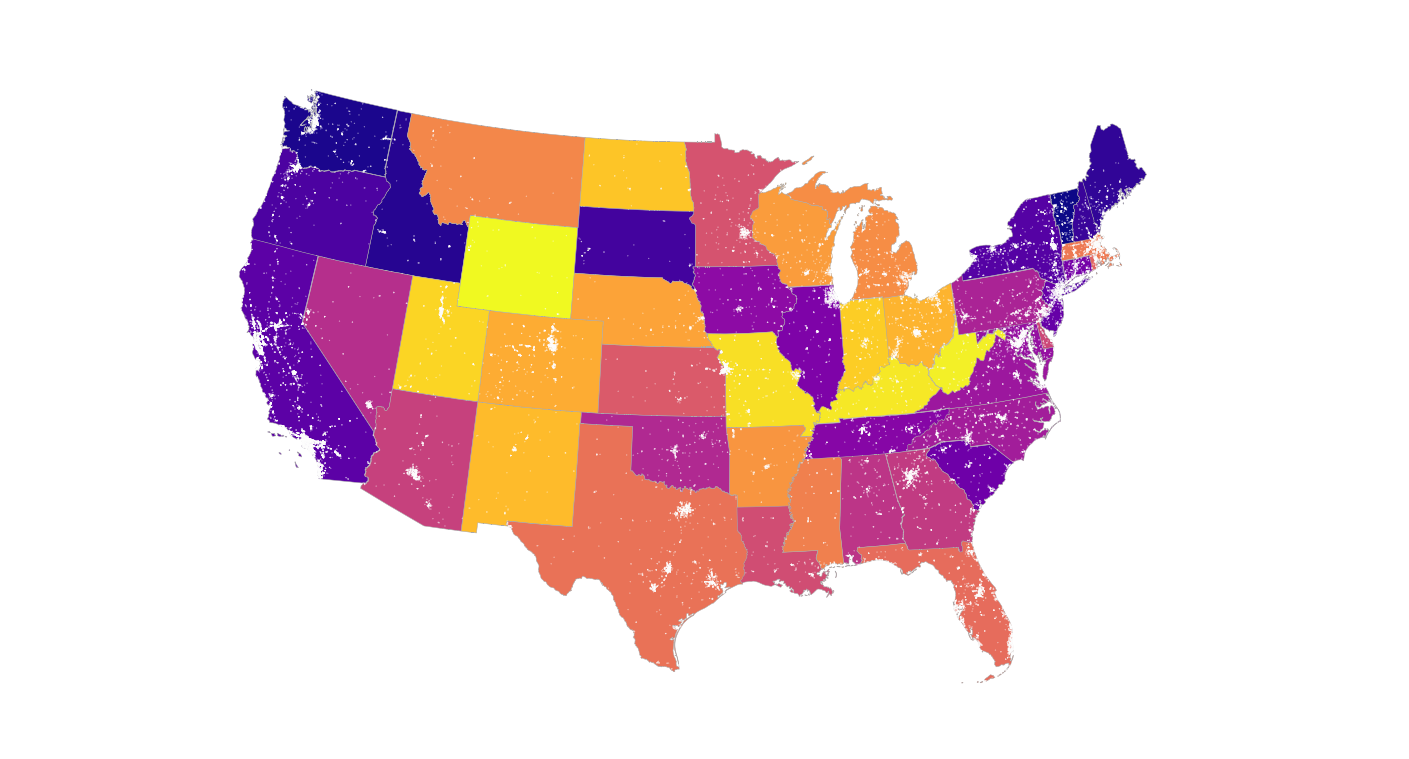

In [12]:
# State codes to plot
al_hi_other = [2,60,15,66,69,72,78]

# Plotting
ax = gplt.choropleth(
  egrid_state[~egrid_state['STATEFP'].isin(al_hi_other)],
  hue = "STCO2RTA",
  edgecolor='darkgrey',
  linewidth=.5,
  cmap="plasma", 
  figsize = (25,25),
  projection=gcrs.AlbersEqualArea(),
  zorder = 1,
)

station_points = station_points[station_points['STATEFP'].notna()]

gplt.pointplot(
  station_points[~station_points['STATEFP'].isin(al_hi_other)],
  projection=gcrs.AlbersEqualArea(),
  ax = ax,
  color = 'white',
  zorder = 2,
  s = .2,
)

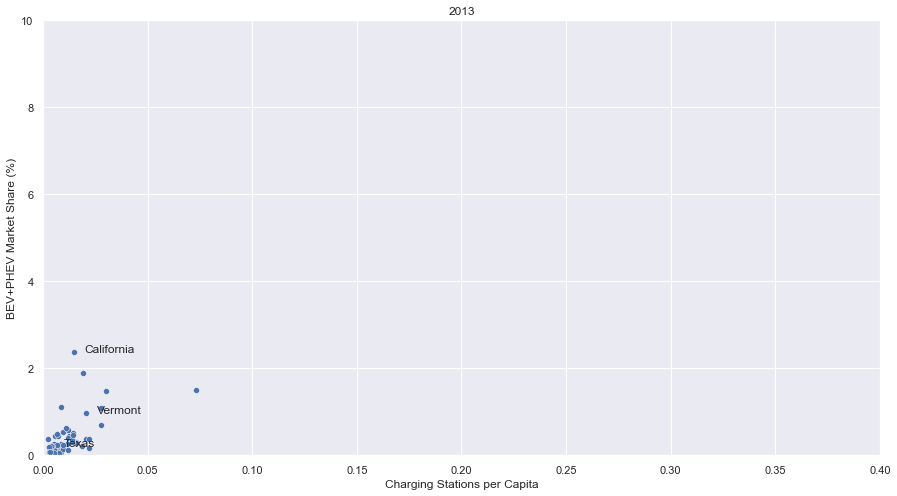

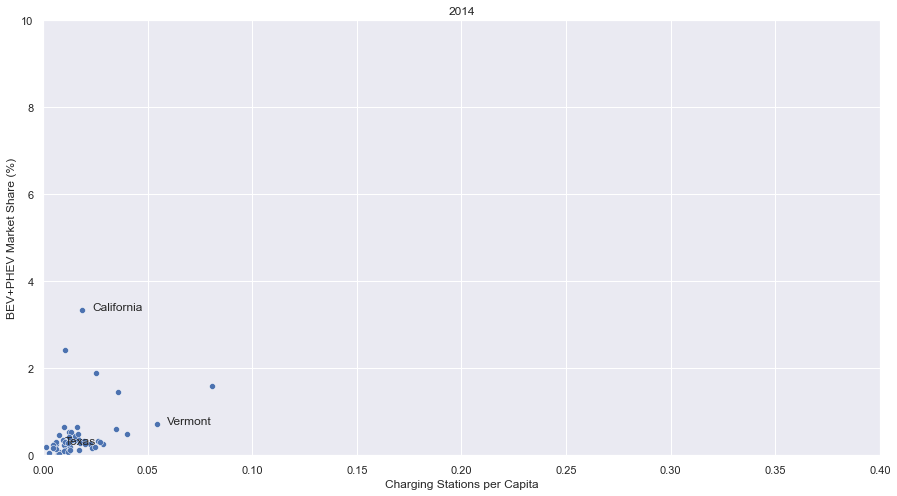

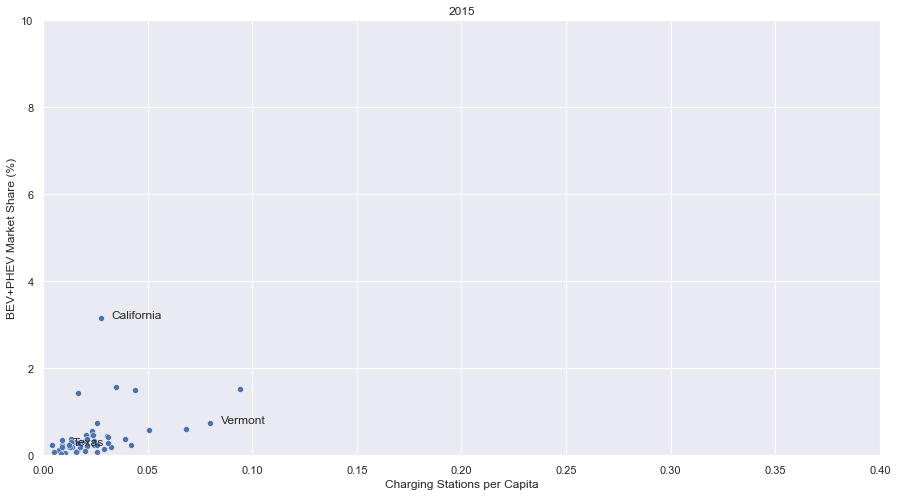

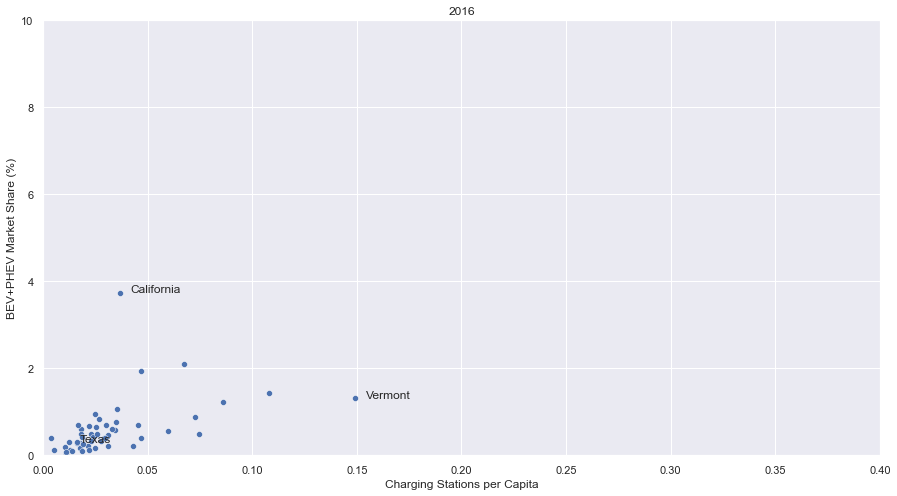

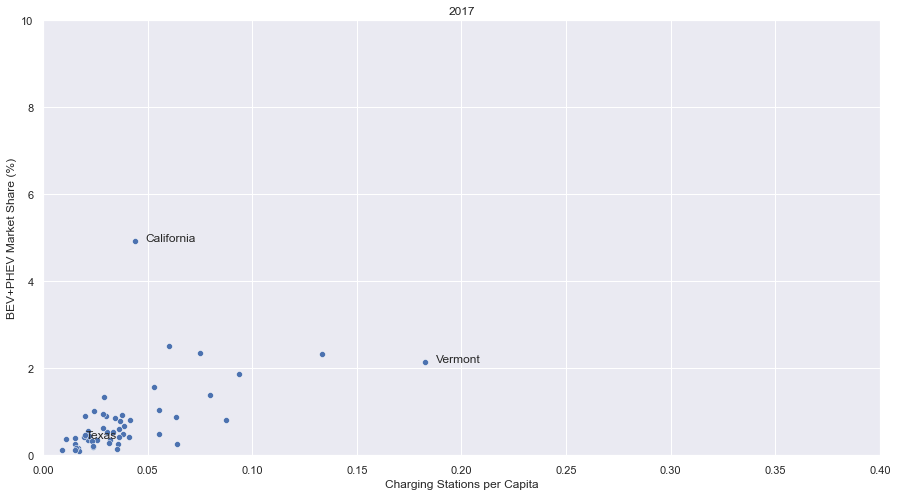

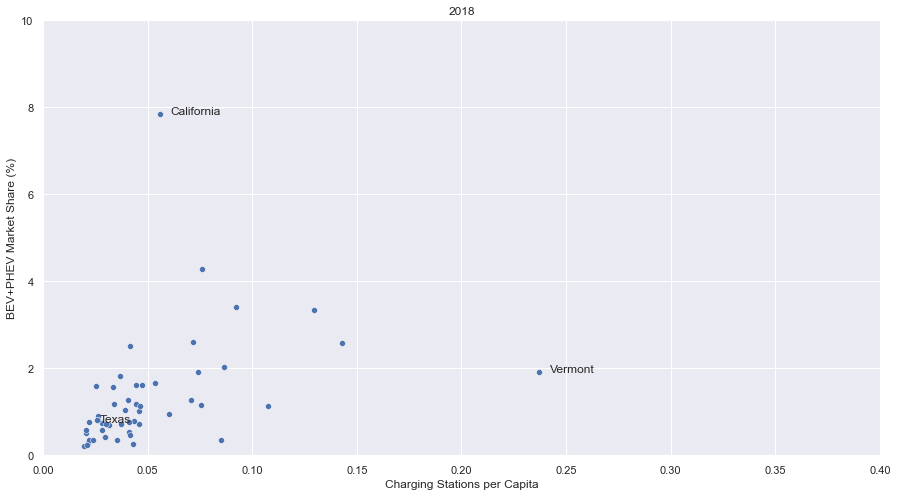

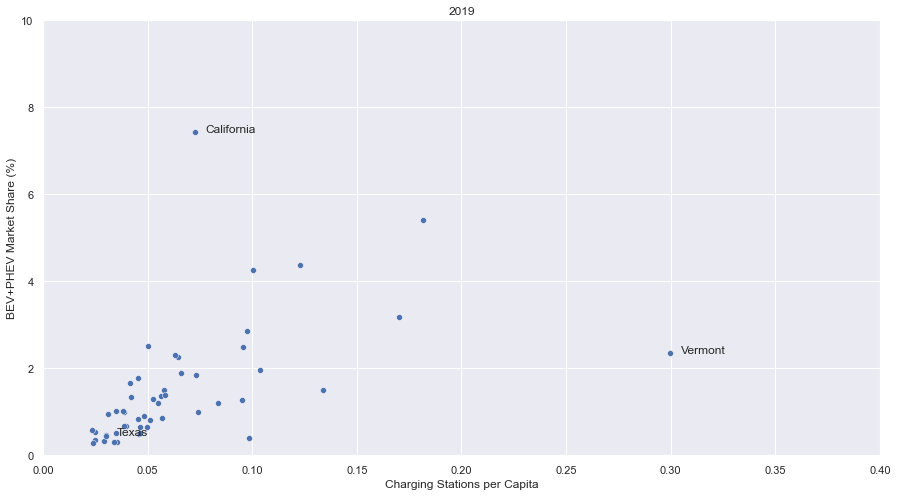

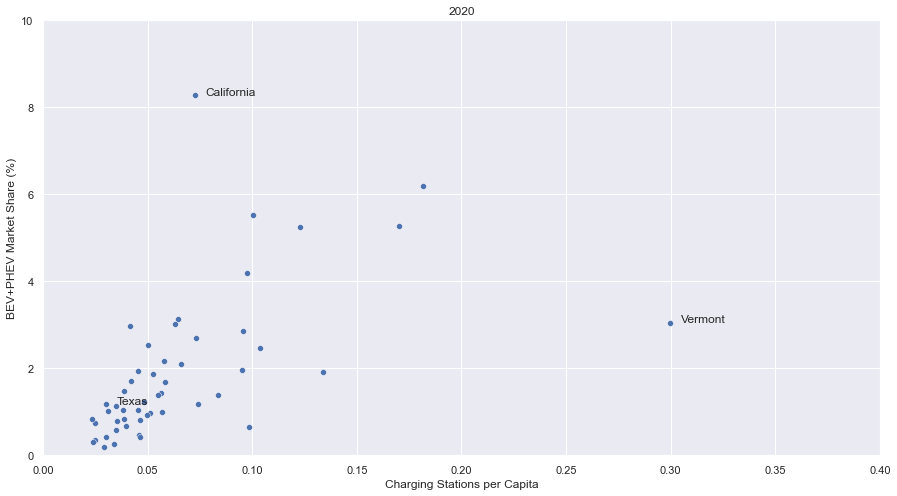

In [13]:
state_pop = pd.read_excel("./Data/Census/PopByState/nst-est2019-01.xlsx")
state_pop['State'] = state_pop['Geographic Area'].map(us_state_to_abbrev)

sns.set_theme()
sns.set(rc = {'figure.figsize':(15,8)})

timeseriesx = []
timeseriesy = []

for year in range(2013, 2021):
    merged_df['Open Date'] = pd.to_datetime(merged_df['Open Date'])
    
    if year == 2020:
        yearpop = 2019
    else:
        yearpop = year
    
    merged_year = merged_df.loc[merged_df['Open Date'] < datetime.datetime(yearpop,12,31)]

    num_stations_by_state = merged_year['State'].value_counts()

    num_stations_by_state = pd.DataFrame(num_stations_by_state)
    num_stations_by_state = num_stations_by_state.reset_index()
    num_stations_by_state.columns = ['State','Charging Stations']

    drop = ["PR", "ON"]

    num_stations_by_state = num_stations_by_state[num_stations_by_state.State.isin(drop) == False]

    ev_market_share = pd.read_excel("./Data/Transport/BEV-PHEV-HEV-FCEV-ICE-Sales-By State-2011-2020-EVAdoption-7.13.21.xlsx", sheet_name= str(year))

    stations_vs_marketshare = pd.merge(state_pop, num_stations_by_state, left_on= "State", right_on="State", how = "right")
    stations_vs_marketshare = pd.merge(stations_vs_marketshare, ev_market_share, left_on= "Geographic Area", right_on="State", how = "left")

    stations_vs_marketshare['Stations Per Capita'] = (stations_vs_marketshare['Charging Stations']/stations_vs_marketshare[str(yearpop)])*1000
    stations_vs_marketshare['EV (BEV & PHEV) Share'] = stations_vs_marketshare['EV (BEV & PHEV) Share']*100

    stations_vs_marketshare[['Geographic Area', 'Stations Per Capita','EV (BEV & PHEV) Share']].head()

    share_v_stations_plot = sns.scatterplot(
        data = stations_vs_marketshare,
        x="Stations Per Capita", y="EV (BEV & PHEV) Share",
    )
    share_v_stations_plot.set_xlabel("Charging Stations per Capita")
    share_v_stations_plot.set_ylabel("BEV+PHEV Market Share (%)")
    share_v_stations_plot.set_title(year)
    share_v_stations_plot.set(xlim=(0, 0.4))
    share_v_stations_plot.set(ylim=(0, 10))


    # Just for fun
    state_labels = ["California", "Vermont", "Texas"]
    i = 0
    # for state in stations_vs_marketshare['Geographic Area']:
    for state in state_labels:
        x = stations_vs_marketshare.loc[stations_vs_marketshare['Geographic Area'] == state, 'Stations Per Capita'].iloc[0]
        y = stations_vs_marketshare.loc[stations_vs_marketshare['Geographic Area'] == state, 'EV (BEV & PHEV) Share'].iloc[0]
        share_v_stations_plot.text(x + 0.005, y - 0.001 , state)
        timeseriesx.append([])
        timeseriesy.append([])
        timeseriesx[i].append(x)
        timeseriesy[i].append(y)

        i = i + 1
        
    plt.show()

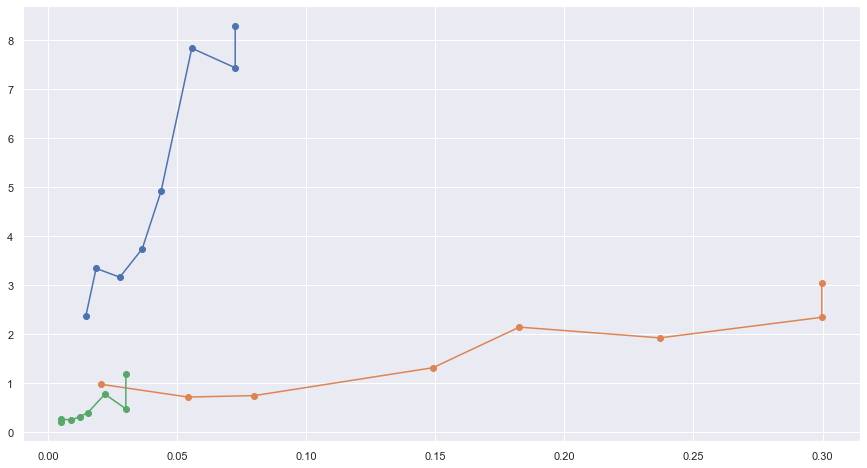

In [14]:
for i in range(0, len(timeseriesx)):
    plt.plot(timeseriesx[i], timeseriesy[i], linestyle='-', marker='o')

In [15]:
tract_pop = pd.read_csv("./Data/Census/Population_Race_Tract/nhgis0003_ds244_20195_tract.csv", encoding='latin-1')
tract_pop

,GISJOIN,YEAR,STUSAB,REGIONA,DIVISIONA,STATE,STATEA,COUNTY,COUNTYA,COUSUBA,PLACEA,TRACTA,BLKGRPA,CONCITA,AIANHHA,RES_ONLYA,TRUSTA,AIHHTLI,AITS,ANRCA,CBSAA,CSAA,METDIVA,MEMI,NECTAA,CNECTAA,NECTADIVA,UAA,CDCURRA,SLDUA,SLDLA,ZCTA5A,SUBMCDA,SDELMA,SDSECA,SDUNIA,UR,PCI,PUMA5A,GEOID,BTTRA,BTBGA,NAME_E,ALUCE001,ALUCE002,ALUCE003,ALUCE004,ALUCE005,ALUCE006,ALUCE007,ALUCE008,ALUCE009,ALUCE010,NAME_M,ALUCM001,ALUCM002,ALUCM003,ALUCM004,ALUCM005,ALUCM006,ALUCM007,ALUCM008,ALUCM009,ALUCM010
0,G0100010020100,2015-2019,AL,NaN,NaN,Alabama,1,Autauga County,1,NaN,NaN,20100,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,14000US01001020100,NaN,NaN,"Census Tract 201, Autauga County, Alabama",1993,1685,152,0,2,0,0,154,0,154,"Census Tract 201, Autauga County, Alabama",225,202,78,12,5,12,12,120,12,120
1,G0100010020200,2015-2019,AL,NaN,NaN,Alabama,1,Autauga County,1,NaN,NaN,20200,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,14000US01001020200,NaN,NaN,"Census Tract 202, Autauga County, Alabama",1959,759,1117,0,0,21,6,56,0,56,"Census Tract 202, Autauga County, Alabama",202,113,180,12,12,32,10,61,12,61
2,G0100010020300,2015-2019,AL,NaN,NaN,Alabama,1,Autauga County,1,NaN,NaN,20300,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,14000US01001020300,NaN,NaN,"Census Tract 203, Autauga County, Alabama",3507,2285,857,0,32,5,233,95,0,95,"Census Tract 203, Autauga County, Alabama",386,306,298,12,29,9,262,101,12,101
3,G0100010020400,2015-2019,AL,NaN,NaN,Alabama,1,Autauga County,1,NaN,NaN,20400,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,14000US01001020400,NaN,NaN,"Census Tract 204, Autauga County, Alabama",3878,3495,216,32,11,0,0,124,14,110,"Census Tract 204, Autauga County, Alabama",317,302,180,43,16,12,12,78,23,69
4,G0100010020500,2015-2019,AL,NaN,NaN,Alabama,1,Autauga County,1,NaN,NaN,20500,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,14000US01001020500,NaN,NaN,"Census Tract 205, Autauga County, Alabama",10596,7982,1929,0,385,0,49,251,0,251,"Census Tract 205, Autauga County, Alabama",707,568,613,19,168,19,113,210,19,210
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
73996,G7201530750501,2015-2019,PR,NaN,NaN,Puerto Rico,72,Yauco Municipio,153,NaN,NaN,750501,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,14000US72153750501,NaN,NaN,"Census Tract 7505.01, Yauco Municipio, Puerto ...",6113,4907,145,80,0,0,912,69,61,8,"Census Tract 7505.01, Yauco Municipio, Puerto ...",834,808,123,123,20,20,360,67,65,12
73997,G7201530750502,2015-2019,PR,NaN,NaN,Puerto Rico,72,Yauco Municipio,153,NaN,NaN,750502,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,14000US72153750502,NaN,NaN,"Census Tract 7505.02, Yauco Municipio, Puerto ...",2388,1763,201,21,0,0,374,29,25,4,"Census Tract 7505.02, Yauco Municipio, Puerto ...",410,339,111,31,14,14,229,39,38,7
73998,G7201530750503,2015-2019,PR,NaN,NaN,Puerto Rico,72,Yauco Municipio,153,NaN,NaN,750503,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,14000US72153750503,NaN,NaN,"Census Tract 7505.03, Yauco Municipio, Puerto ...",2126,1525,86,0,6,0,475,34,12,22,"Census Tract 7505.03, Yauco Municipio, Puerto ...",402,394,72,14,8,14,221,34,13,32
73999,G7201530750601,2015-2019,PR,NaN,NaN,Puerto Rico,72,Yauco Municipio,153,NaN,NaN,750601,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,14000US721537506

In [16]:
tract_sf = gpd.read_file("./Data/GIS/cb_2020_us_tract_500k/cb_2020_us_tract_500k.shp")
tract_sf

,STATEFP,COUNTYFP,TRACTCE,AFFGEOID,GEOID,NAME,NAMELSAD,STUSPS,NAMELSADCO,STATE_NAME,LSAD,ALAND,AWATER,geometry
0,06,077,005127,1400000US06077005127,06077005127,51.27,Census Tract 51.27,CA,San Joaquin County,California,CT,1960015,0,"POLYGON ((-121.28708 37.83381, -121.28499 37.8..."
1,06,077,003406,1400000US06077003406,06077003406,34.06,Census Tract 34.06,CA,San Joaquin County,California,CT,839414,14789,"POLYGON ((-121.30900 38.02824, -121.30461 38.0..."
2,06,077,004402,1400000US06077004402,06077004402,44.02,Census Tract 44.02,CA,San Joaquin County,California,CT,4346363,0,"POLYGON ((-121.27339 38.10811, -121.27286 38.1..."
3,06,077,005124,1400000US06077005124,06077005124,51.24,Census Tract 51.24,CA,San Joaquin County,California,CT,1084165,0,"POLYGON ((-121.23525 37.81203, -121.23127 37.8..."
4,06,077,001700,1400000US06077001700,06077001700,17,Census Tract 17,CA,San Joaquin County,California,CT,1685934,0,"POLYGON ((-121.26642 37.97530, -121.26453 37.9..."
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
85183,21,015,070202,1400000US21015070202,21015070202,702.02,Census Tract 702.02,KY,Boone County,Kentucky,CT,2099589,0,"POLYGON ((-84.63816 38.98948, -84.63645 38.991..."
85184,06,013,313106,1400000US06013313106,06013313106,3131.06,Census Tract 3131.06,CA,Contra Costa County,California,CT,12901293,0,"POLYGON ((-121.89870 37.98367, -121.89775 37.9..."
85185,06,013,355202,1400000US06013355202,06013355202,3552.02,Census Tract 3552.02,CA,Contra Costa County,California,CT,25942991,0,"POLYGON ((-122.02533 38.00287, -122.02398 38.0..."
85186,28,053,950200,1400000US28053950200,28053950200,9502,Census Tract 9502,MS,Humphreys County,Mississippi,CT,654641262,20908703,"POLYGON ((-90.73294 33.23507, -90.73089 33.242..."


In [17]:
geometry = [Point(xy) for xy in zip(station_data.Longitude, station_data.Latitude)]
crs = {'init' :'epsg:4326'}
station_points = gpd.GeoDataFrame(station_data, crs=crs, geometry=geometry)

station_points_tract = gpd.sjoin(station_points, tract_sf, how='left', op='within')


C:\Users\Casey\anaconda3\envs\Geospatial\lib\site-packages\pyproj\crs\crs.py:131: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)
C:\Users\Casey\AppData\Local\Temp\ipykernel_10172\2391972446.py:5: UserWarning: CRS mismatch between the CRS of left geometries and the CRS of right geometries.
Use `to_crs()` to reproject one of the input geometries to match the CRS of the other.

Left CRS: +init=epsg:4326 +type=crs
Right CRS: EPSG:4269

  station_points_tract = gpd.sjoin(station_points, tract_sf, how='left', op='within')


<GeoAxesSubplot:>

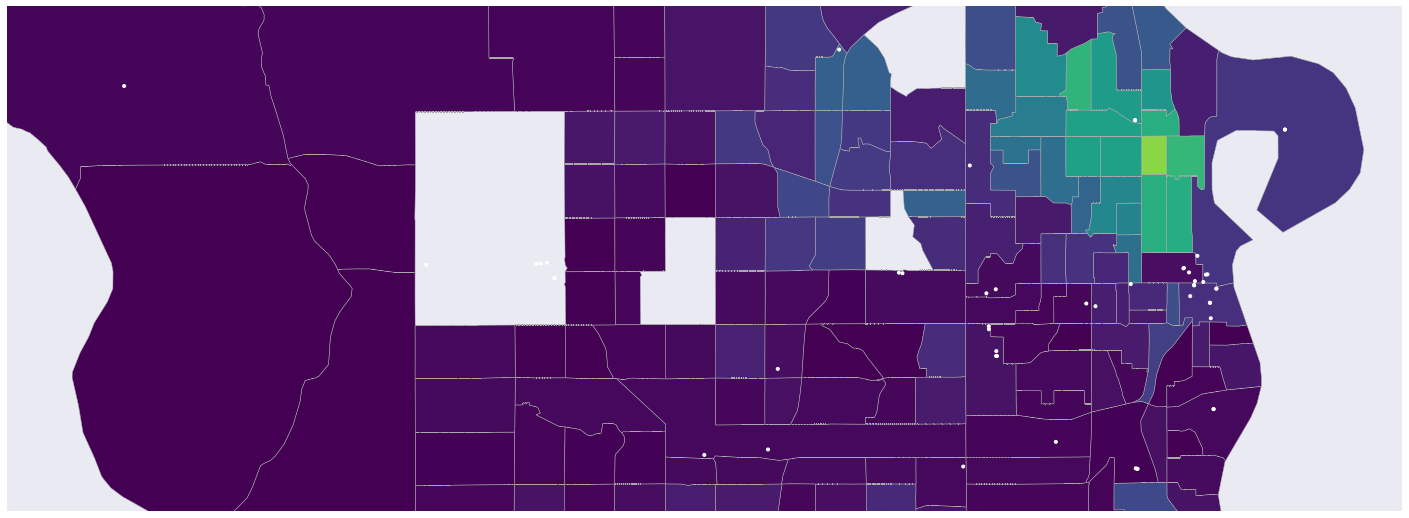

In [28]:
tract_pop['GEOID'] = tract_pop['GEOID'].map(lambda x: x.lstrip('14000'))
tract_sf['AFFGEOID'] = tract_sf['AFFGEOID'].map(lambda x: x.lstrip('1400000'))

tract_data = tract_sf.merge(tract_pop, left_on = 'AFFGEOID', right_on = 'GEOID', how = 'inner')
tract_data['Black_Percent'] = (tract_data['ALUCE003']/tract_data['ALUCE001'])*100

norm = plt.Normalize(0, 100)

# Omaha
statefp = ['31']
countyfp = ['055']

# Plotting
ax = gplt.choropleth(
  tract_data[(tract_data['STATEFP'].isin(statefp)) & (tract_data['COUNTYFP'].isin(countyfp))],
  hue = "Black_Percent",
  # legend=True,
  # legend_kwargs={'boundaries': (0,100,200,300,400)},
  edgecolor='darkgrey',
  linewidth=.5,
  cmap="viridis",
  norm = norm,
  figsize = (25,25),
  projection=gcrs.AlbersEqualArea(),
  zorder = 1
)

gplt.pointplot(
  station_points_tract[(station_points_tract['STATEFP'].isin(statefp)) & (station_points_tract['COUNTYFP'].isin(countyfp))],
  projection=gcrs.AlbersEqualArea(),
  ax = ax,
  color = 'white',
  zorder = 2,
  s = 3,
)



C:\Users\Casey\anaconda3\envs\Geospatial\lib\site-packages\geoplot\geoplot.py:66: UserWarning: The data being passed to "hue" includes null values. You probably want to remove these before plotting this data with geoplot.
  warnings.warn(


<GeoAxesSubplot:>

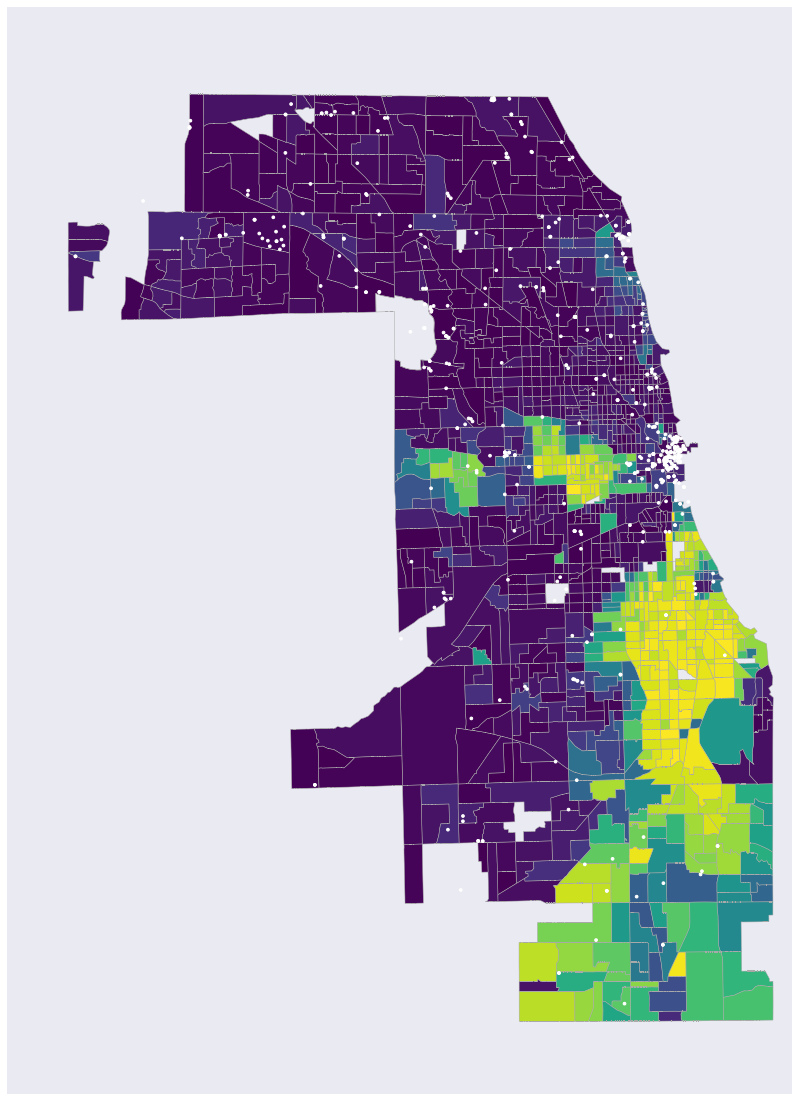

In [41]:
#Chicago
statefp = ['17']
# countyfp = ['031', '043', '197']
countyfp = ['031']

# Plotting
ax = gplt.choropleth(
  tract_data[(tract_data['STATEFP'].isin(statefp)) & (tract_data['COUNTYFP'].isin(countyfp))],
  hue = "Black_Percent",
  # legend=True,
  edgecolor='darkgrey',
  linewidth=.5,
  cmap="viridis", 
  norm = norm,
  figsize = (20,20),
  projection=gcrs.AlbersEqualArea(),
  zorder = 1,
)

gplt.pointplot(
  station_points_tract[(station_points_tract['STATEFP'].isin(statefp)) & (station_points_tract['COUNTYFP'].isin(countyfp))],
  projection=gcrs.AlbersEqualArea(),
  ax = ax,
  color = 'white',
  zorder = 2,
  s = 2.7,
)

C:\Users\Casey\anaconda3\envs\Geospatial\lib\site-packages\geoplot\geoplot.py:66: UserWarning: The data being passed to "hue" includes null values. You probably want to remove these before plotting this data with geoplot.
  warnings.warn(


<GeoAxesSubplot:>

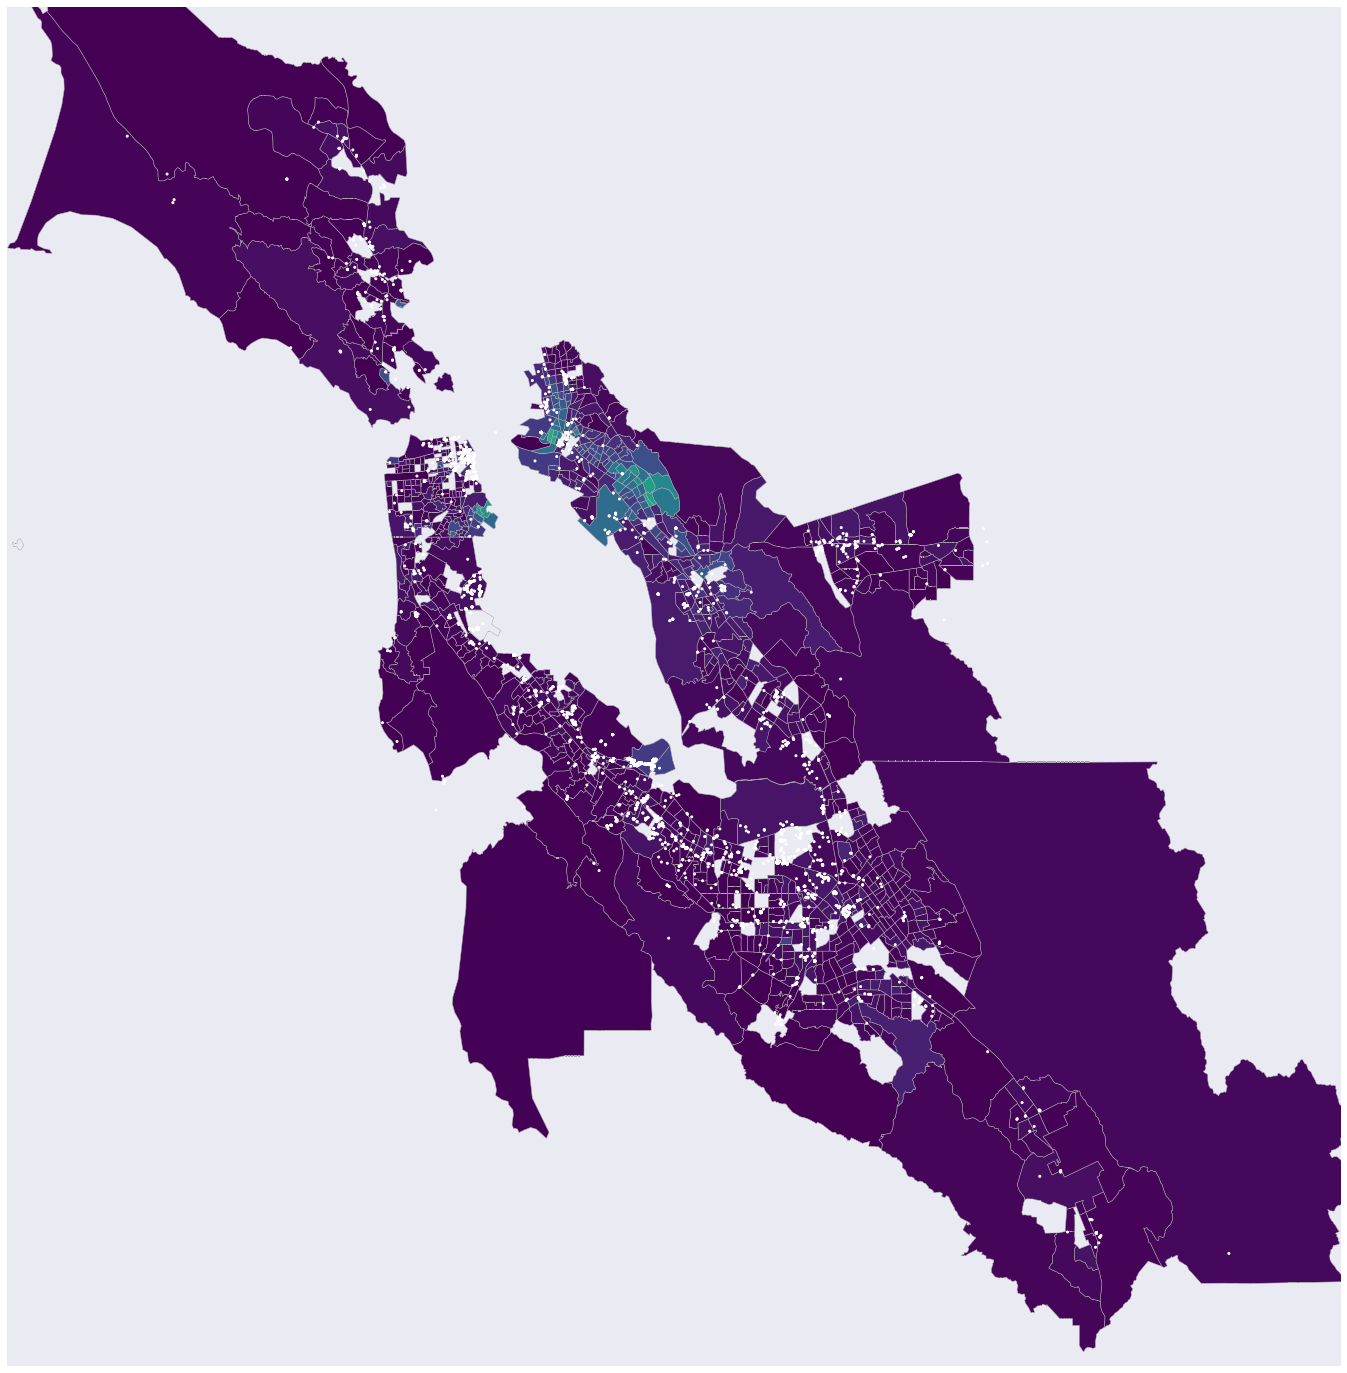

In [30]:
#San Francisco

statefp = ['06']
countyfp = ['075', '081', '041', '001', '085']

# Plotting
ax = gplt.choropleth(
  tract_data[(tract_data['STATEFP'].isin(statefp)) & (tract_data['COUNTYFP'].isin(countyfp))],
  hue = "Black_Percent",
  # legend=True,
  edgecolor='darkgrey',
  linewidth=.5,
  cmap="viridis", 
  norm = norm,
  figsize = (25,25),
  projection=gcrs.AlbersEqualArea(),
  zorder = 1,
)

gplt.pointplot(
  station_points_tract[(station_points_tract['STATEFP'].isin(statefp)) & (station_points_tract['COUNTYFP'].isin(countyfp))],
  projection=gcrs.AlbersEqualArea(),
  ax = ax,
  color = 'white',
  zorder = 2,
  s = 2,
)

C:\Users\Casey\anaconda3\envs\Geospatial\lib\site-packages\geoplot\geoplot.py:66: UserWarning: The data being passed to "hue" includes null values. You probably want to remove these before plotting this data with geoplot.
  warnings.warn(


<GeoAxesSubplot:>

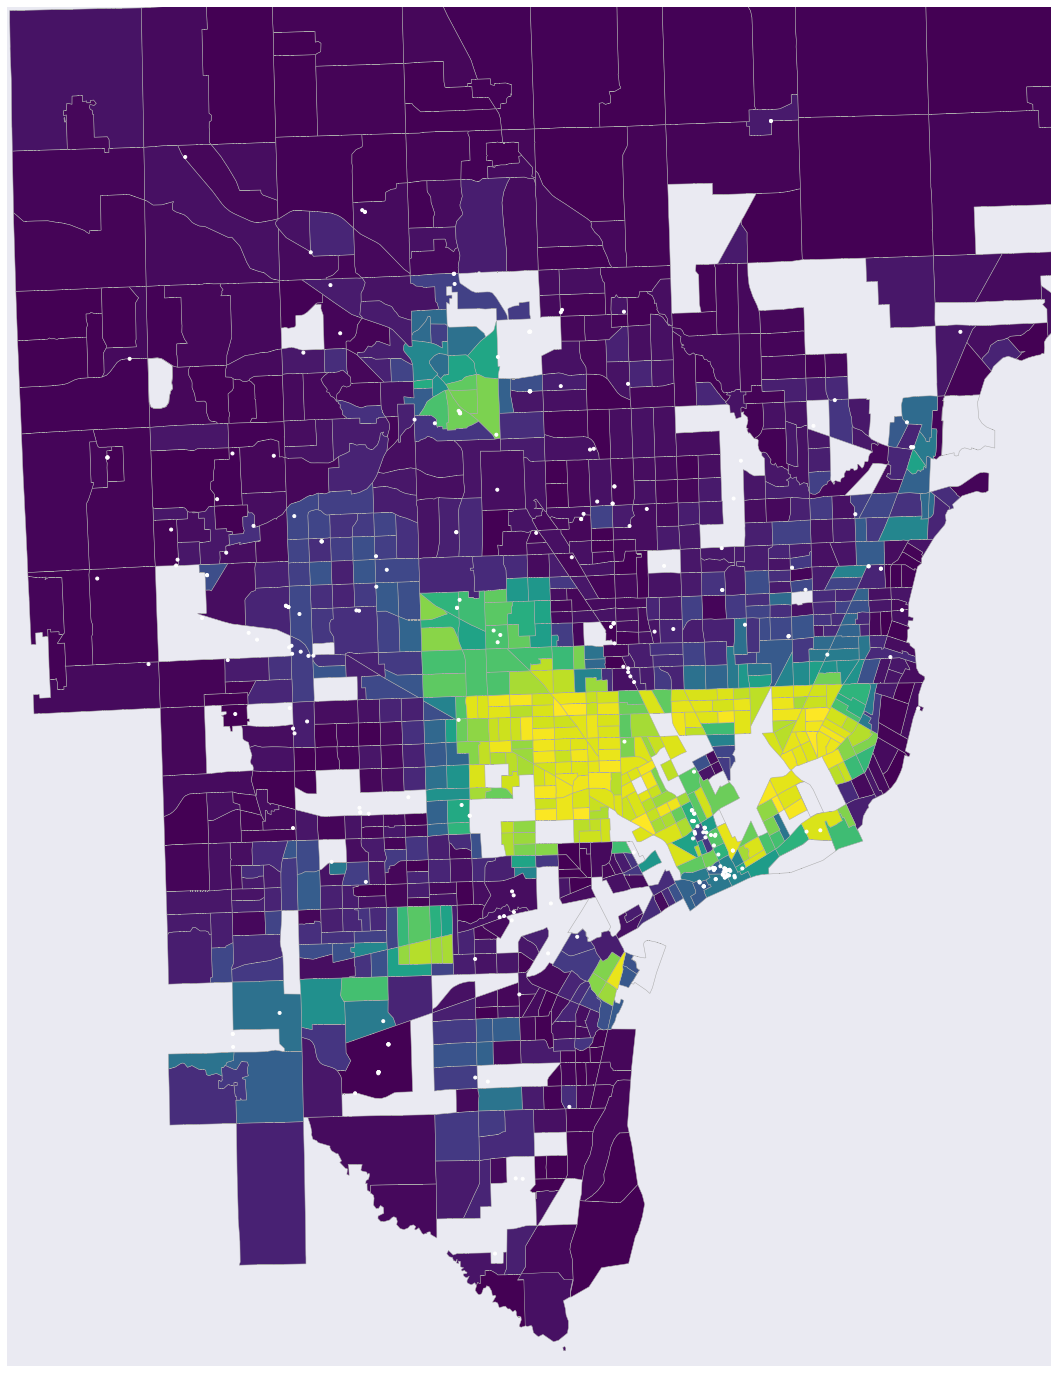

In [31]:
#Detroit

statefp = ['26']
countyfp = ['163', '125', '099']

# Plotting
ax = gplt.choropleth(
  tract_data[(tract_data['STATEFP'].isin(statefp)) & (tract_data['COUNTYFP'].isin(countyfp))],
  hue = "Black_Percent",
  # legend=True,
  edgecolor='darkgrey',
  linewidth=.5,
  cmap="viridis",
  norm = norm, 
  figsize = (25,25),
  projection=gcrs.AlbersEqualArea(),
  zorder = 1,
)

gplt.pointplot(
  station_points_tract[(station_points_tract['STATEFP'].isin(statefp)) & (station_points_tract['COUNTYFP'].isin(countyfp))],
  projection=gcrs.AlbersEqualArea(),
  ax = ax,
  color = 'white',
  zorder = 2,
  s =3,
)

C:\Users\Casey\AppData\Local\Temp\ipykernel_10172\981926576.py:4: MatplotlibDeprecationWarning: Auto-removal of grids by pcolor() and pcolormesh() is deprecated since 3.5 and will be removed two minor releases later; please call grid(False) first.
  cb = mpl.colorbar.ColorbarBase(ax,


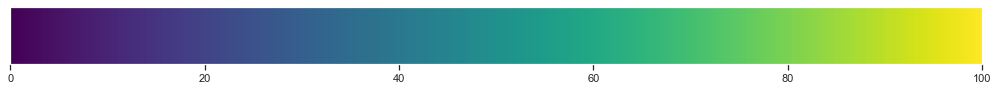

In [40]:
fig = plt.figure()
ax = fig.add_axes([0.05, 0.80, 0.9, 0.1])

cb = mpl.colorbar.ColorbarBase(ax,
    orientation='horizontal', 
    cmap='viridis',
    norm = norm)

C:\Users\Casey\AppData\Local\Temp\ipykernel_10172\3543325148.py:4: MatplotlibDeprecationWarning: Auto-removal of grids by pcolor() and pcolormesh() is deprecated since 3.5 and will be removed two minor releases later; please call grid(False) first.
  cb = mpl.colorbar.ColorbarBase(ax,


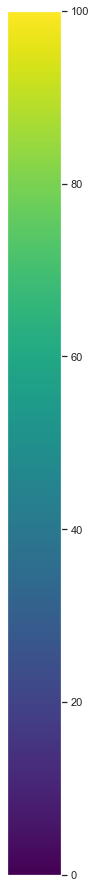

In [39]:
fig = plt.figure()
ax = fig.add_axes([0.8, 0.05, 0.05, 1.5])

cb = mpl.colorbar.ColorbarBase(ax, 
    orientation='vertical', 
    cmap='viridis',
    norm = norm)